# Training MNet

In [2]:
import numpy as np
from keras import backend as K
import scipy
from skimage.measure import label, regionprops
from skimage.transform import resize
import os
from PIL import Image
from keras.preprocessing import image
import tensorflow as tf
from keras.optimizers import SGD
from keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,
    Activation, Conv2DTranspose, Multiply, Add, AveragePooling2D, Average
)
from keras.models import Model
import random
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## Utils

In [3]:
# Define helper functions
def mk_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    return dir_path

def return_list(data_path, data_type):
    file_list = [file for file in os.listdir(data_path) if file.lower().endswith(data_type)]
    print(str(len(file_list)))
    return file_list

def train_loader(data_list, data_path, mask_path, input_size):
    for lineIdx in range(len(data_list)):
        temp_txt = data_list[lineIdx]

        train_img = np.asarray(image.load_img(
            os.path.join(data_path, temp_txt),
            target_size=(input_size, input_size, 3))
        ).astype('float32')

        img_mask = np.asarray(image.load_img(
            os.path.join(mask_path, temp_txt),
            target_size=(input_size, input_size, 3))) / 255.0

        img_mask = img_mask.astype('float32')

        yield (train_img, (img_mask, img_mask, img_mask, img_mask, img_mask))


def tf_data_loader(data_list, data_path, mask_path, input_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: train_loader(data_list, data_path, mask_path, input_size),
        output_signature=(
            tf.TensorSpec(shape=(input_size, input_size, 3), dtype=tf.float32),
            tuple([tf.TensorSpec(shape=(input_size, input_size, 3), dtype=tf.float32)] * 5)
        )
    )
    return dataset

def pro_process(temp_img, input_size):
    img = np.asarray(temp_img).astype('float32')  # Ensure float32 dtype
    img = resize(img, (input_size, input_size, 3), preserve_range=True)  # Resize and preserve range
    return img

def BW_img(input, thresholding):
    if input.max() > thresholding:
        binary = input > thresholding
    else:
        binary = input > input.max()/2.0

    label_image = label(binary)
    regions = regionprops(label_image)
    area_list = []
    for region in regions:
        area_list.append(region.area)
    if area_list:
        idx_max = np.argmax(area_list)
        binary[label_image != idx_max+1] = 0
    return scipy.ndimage.binary_fill_holes(np.asarray(binary).astype(int))
    
def disc_crop(org_img, DiscROI_size, C_x, C_y):
    tmp_size = int(DiscROI_size/2)
    disc_region = np.zeros((DiscROI_size, DiscROI_size, 3), dtype= org_img.dtype)
    crop_coord = np.array([C_x-tmp_size, C_x+tmp_size, C_y-tmp_size, C_y+tmp_size], dtype= int)
    err_coord = [0, DiscROI_size, 0, DiscROI_size]

    if crop_coord[0] < 0:
        err_coord[0] = abs(crop_coord[0])
        crop_coord[0] = 0

    if crop_coord[2] < 0:
        err_coord[2] = abs(crop_coord[2])
        crop_coord[2] = 0

    if crop_coord[1] > org_img.shape[0]:
        err_coord[1] = err_coord[1] - (crop_coord[1] - org_img.shape[0])
        crop_coord[1] = org_img.shape[0]

    if crop_coord[3] > org_img.shape[1]:
        err_coord[3] = err_coord[3] - (crop_coord[3] - org_img.shape[1])
        crop_coord[3] = org_img.shape[1]

    disc_region[err_coord[0]:err_coord[1], err_coord[2]:err_coord[3], ] = org_img[crop_coord[0]:crop_coord[1], crop_coord[2]:crop_coord[3], ]

    return disc_region, err_coord, crop_coord

In [4]:
# Training Settings
result_path = mk_dir('/kaggle/working/output_deep_model/')
pre_model_file = '/kaggle/input/deep-model/deep_model/Model_MNet_REFUGE.h5'
save_model_file = result_path + 'Model_MNet_REFUGE_v2.keras'

root_path = '/kaggle/input/training-data-polar/training_crop/'
train_data_path = root_path + 'data/'
train_mask_path = root_path + 'label/'

val_data_path = root_path + 'val_data/data/'
val_mask_path = root_path + 'val_data/label/'

train_list = return_list(train_data_path, '.png')
val_list = return_list(val_data_path, '.png')

1400
300


## Model MNet

In [5]:
from keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,
    Activation, Conv2DTranspose, Multiply, Add, AveragePooling2D, Average
)
from keras.models import Model

def attention_gate(x, g, inter_channels):
    # x: Input feature map from the encoder (skip connection)
    # g: Gating signal from the decoder
    # inter_channels: Number of filters for intermediate computations

    theta_x = Conv2D(inter_channels, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = Conv2D(inter_channels, (1, 1), padding='same')(g)
    add = Add()([theta_x, phi_g])
    relu = Activation('relu')(add)
    psi = Conv2D(1, (1, 1), padding='same')(relu)
    sigmoid = Activation('sigmoid')(psi)
    upsampled = UpSampling2D(size=(2, 2), interpolation='bilinear')(sigmoid)
    attn_coefficients = Multiply()([x, upsampled])
    return attn_coefficients

def DeepModel(size_set=800):

    img_input = Input(shape=(size_set, size_set, 3))

    # Scaled inputs
    scale_img_2 = AveragePooling2D(pool_size=(2, 2))(img_input)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2))(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2))(scale_img_3)

    # Block 1
    conv1 = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2
    input2 = Conv2D(64, (3, 3), padding='same', name='block2_input1')(scale_img_2)
    input2 = BatchNormalization()(input2)
    input2 = Activation('relu')(input2)
    input2 = concatenate([input2, pool1], axis=3)
    conv2 = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(input2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3
    input3 = Conv2D(128, (3, 3), padding='same', name='block3_input1')(scale_img_3)
    input3 = BatchNormalization()(input3)
    input3 = Activation('relu')(input3)
    input3 = concatenate([input3, pool2], axis=3)
    conv3 = Conv2D(128, (3, 3), padding='same', name='block3_conv1')(input3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same', name='block3_conv2')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4
    input4 = Conv2D(256, (3, 3), padding='same', name='block4_input1')(scale_img_4)
    input4 = BatchNormalization()(input4)
    input4 = Activation('relu')(input4)
    input4 = concatenate([input4, pool3], axis=3)
    conv4 = Conv2D(256, (3, 3), padding='same', name='block4_conv1')(input4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same', name='block4_conv2')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bridge
    conv5 = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # Decoder with Attention Gates
    # Up Block 6
    attn4 = attention_gate(conv4, conv5, inter_channels=256)
    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='block6_dconv')(conv5)
    up6 = concatenate([up6, attn4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same', name='block6_conv1')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(256, (3, 3), padding='same', name='block6_conv2')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    # Up Block 7
    attn3 = attention_gate(conv3, conv6, inter_channels=128)
    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='block7_dconv')(conv6)
    up7 = concatenate([up7, attn3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same', name='block7_conv1')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(128, (3, 3), padding='same', name='block7_conv2')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    # Up Block 8
    attn2 = attention_gate(conv2, conv7, inter_channels=64)
    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='block8_dconv')(conv7)
    up8 = concatenate([up8, attn2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same', name='block8_conv1')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(64, (3, 3), padding='same', name='block8_conv2')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    # Up Block 9
    attn1 = attention_gate(conv1, conv8, inter_channels=32)
    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='block9_dconv')(conv8)
    up9 = concatenate([up9, attn1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same', name='block9_conv1')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(32, (3, 3), padding='same', name='block9_conv2')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    # Side Outputs with 1 channel each
    side6 = UpSampling2D(size=(8, 8))(conv6)
    side7 = UpSampling2D(size=(4, 4))(conv7)
    side8 = UpSampling2D(size=(2, 2))(conv8)
    out6 = Conv2D(3, (1, 1), activation='softmax', name='side_63')(side6)
    out7 = Conv2D(3, (1, 1), activation='softmax', name='side_73')(side7)
    out8 = Conv2D(3, (1, 1), activation='softmax', name='side_83')(side8)
    out9 = Conv2D(3, (1, 1), activation='softmax', name='side_93')(conv9)
    
    # Final Output with name 'final_output'
    out10 = Average(name='final_output')([out6, out7, out8, out9])

    model = Model(inputs=[img_input], outputs=[out6, out7, out8, out9, out10])

    return model

In [6]:
# Define the Dice Loss function
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice Loss for multiclass segmentation.
    """
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice_score = (2. * intersection + smooth) / (denominator + smooth)
    return 1 - tf.reduce_mean(dice_score)

# Training 

In [7]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, average


def DeepModel1(size_set = 640):

    img_input = Input(shape=(size_set, size_set, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv1')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv2')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='block6_dconv')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block6_conv1')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block6_conv2')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='block7_dconv')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block7_conv1')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block7_conv2')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='block8_dconv')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block8_conv1')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block8_conv2')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='block9_dconv')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block9_conv1')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block9_conv2')(conv9)

    side6 = UpSampling2D(size=(8, 8))(conv6)
    side7 = UpSampling2D(size=(4, 4))(conv7)
    side8 = UpSampling2D(size=(2, 2))(conv8)
    out6 = Conv2D(1, (1, 1), activation='sigmoid', name='side_6')(side6)
    out7 = Conv2D(1, (1, 1), activation='sigmoid', name='side_7')(side7)
    out8 = Conv2D(1, (1, 1), activation='sigmoid', name='side_8')(side8)
    out9 = Conv2D(1, (1, 1), activation='sigmoid', name='side_9')(conv9)

    out10 = average([out6, out7, out8, out9])
    #out10 = Conv2D(1, (1, 1), activation='sigmoid', name='side_10')(out10)

    model = Model(inputs=[img_input], outputs=[out10])

    return model

DiscSeg_size = 640
DiscSeg_model = DeepModel1(DiscSeg_size)
DiscSeg_model.load_weights('/kaggle/input/deep-model/deep_model/Model_DiscSeg_ORIGA.h5')

In [8]:
input_size = 224
batch_size = 8
epochs = 100  # Total number of epochs to train

train_list = return_list(train_data_path, '.png')
val_list = return_list(val_data_path, '.png')

# Create TensorFlow datasets
train_dataset = tf_data_loader(train_list, train_data_path, train_mask_path, input_size)
val_dataset = tf_data_loader(val_list, val_data_path, val_mask_path, input_size)

# Calculate steps per epoch
steps_per_epoch = len(train_list) // batch_size
validation_steps = len(val_list) // batch_size

# Prepare the datasets
train_dataset = (
    train_dataset
    .shuffle(buffer_size=len(train_list), reshuffle_each_iteration=True)
    .batch(batch_size)
    .repeat()  # Repeat indefinitely
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    val_dataset
    .batch(batch_size)
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)


# Initialize the model
my_model = DeepModel(size_set=input_size)

# Define the optimizer
optimizer_setting = SGD(learning_rate=0.0001, momentum=0.9)

# Compile the model
my_model.compile(
    optimizer=optimizer_setting,
    loss=dice_loss,
    loss_weights=[0.1, 0.1, 0.1, 0.1, 0.6]
)


# Define callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint(
    filepath=save_model_file,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

my_model.load_weights('/kaggle/input/weights/Model_MNet_AttGates.keras')
# Train the model
# history = my_model.fit(
#     train_dataset,
#     epochs=epochs,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=val_dataset,
#     validation_steps=validation_steps,
#     callbacks=[checkpoint, early_stopping],
#     verbose=1
# )

1400
300


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Validation try

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
# Function to load a single image and mask
def load_single_image(img_path, mask_path, target_size):
    # Load and preprocess the image
    img = np.asarray(image.load_img(
        img_path,
        target_size=(target_size, target_size, 3))
    ).astype('float32')
    
    # Load and preprocess the mask
    img_mask = image.load_img(
        mask_path,
        target_size=(target_size, target_size),
        color_mode='grayscale')
    
    img_mask = np.asarray(img_mask).astype('int32')
    
    return img, img_mask

# Select a sample from the validation set
sample_index = 4
sample_img_name = val_list[sample_index]
sample_mask_name = val_list[sample_index]  # Assuming mask filenames are the same as image filenames

sample_img_path = os.path.join(val_data_path, sample_img_name)
sample_mask_path = os.path.join(val_mask_path, sample_mask_name)

print(sample_img_name)
print(sample_mask_name)

# Load the image and mask
input_size = 224  # Ensure this matches your model's expected input size
img, mask = load_single_image(sample_img_path, sample_mask_path, input_size)
img_input = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict
predictions = my_model.predict(img_input)
final_output = predictions[-1][0]  # Extract the first sample from the batch

# Since the model outputs softmax probabilities over 3 classes, take the argmax to get predicted class labels
predicted_mask = np.argmax(final_output, axis=-1)


# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img/255.0)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask)
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

In [10]:
# import os
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from skimage import transform, feature
# from scipy.io import savemat
# from keras.preprocessing import image

# # Function definitions (fun_CalCDR, fun_DiscFit, maskEllipse, fun_Ell_Fit)
# def fun_CalCDR(disc_map, cup_map):
#     disc_x, disc_y = np.nonzero(disc_map > 0)
#     cup_x, cup_y = np.nonzero(cup_map > 0)
    
#     if disc_x.size > 0:
#         disc_dia = disc_x.max() - disc_x.min()
#     else:
#         disc_dia = 1
    
#     if cup_x.size > 0:
#         cup_dia = cup_x.max() - cup_x.min()
#     else:
#         cup_dia = 1
    
#     CDR = cup_dia / disc_dia
#     return CDR

# def fun_DiscFit(tmp_map):
#     ellp = {}
#     tmp_map_uint8 = (tmp_map * 255).astype(np.uint8)
#     edge_disc = cv2.Canny(tmp_map_uint8, threshold1=50, threshold2=150)
#     tmp_y, tmp_x = np.nonzero(edge_disc > 0)
#     points = np.column_stack((tmp_x, tmp_y))
    
#     print(f"Number of edge points detected: {len(points)}")
    
#     if len(points) < 5:
#         print("Not enough points to fit an ellipse.")
#         ellp['z'] = (0, 0)
#         ellp['a'] = 0
#         ellp['b'] = 0
#         ellp['alpha'] = 0
#         ellp['X'] = np.array([])
#         return ellp
    
#     # Ensure correct dtype and shape
#     points = points.astype(np.float32)
#     points = points.reshape(-1, 1, 2)
    
#     try:
#         ellipse = cv2.fitEllipse(points)
#         center = ellipse[0]
#         axes = ellipse[1]
#         angle = ellipse[2]
        
#         ellp['z'] = center
#         ellp['a'] = axes[0] / 2
#         ellp['b'] = axes[1] / 2
#         ellp['alpha'] = np.deg2rad(angle)
        
#         npts = 100
#         t = np.linspace(0, 2 * np.pi, npts)
        
#         # Rotation matrix
#         Q = np.array([[np.cos(ellp['alpha']), -np.sin(ellp['alpha'])],
#                       [np.sin(ellp['alpha']),  np.cos(ellp['alpha'])]])
        
#         # Ellipse points
#         ellp_X = Q @ np.array([ellp['a'] * np.cos(t), ellp['b'] * np.sin(t)]) + np.array(ellp['z']).reshape(2, 1)
#         ellp['X'] = ellp_X
#     except cv2.error as e:
#         print("cv2.fitEllipse failed:", e)
#         ellp['z'] = (0, 0)
#         ellp['a'] = 0
#         ellp['b'] = 0
#         ellp['alpha'] = 0
#         ellp['X'] = np.array([])
#     return ellp

# def maskEllipse(img_h, img_w, center_y, center_x, a, b, alpha):
#     # Create an empty mask
#     mask = np.zeros((img_h, img_w), dtype=np.uint8)
#     center = (int(round(center_x)), int(round(center_y)))  # (x, y)
#     axes = (int(round(a)), int(round(b)))  # (major_axis, minor_axis)
#     angle = np.rad2deg(alpha)
    
#     # Draw filled ellipse on mask
#     cv2.ellipse(mask, center, axes, angle, 0, 360, 1, thickness=-1)
#     return mask

# def fun_Ell_Fit(prob_map, img_h, img_w, IsFit):
#     Ellp = {}
#     # Resize the map if necessary (assuming prob_map is already the correct size)
#     Ellp['raw_map'] = prob_map.astype(np.uint8)
    
#     if IsFit == 1:
#         Ellp['ellp_para'] = fun_DiscFit(Ellp['raw_map'])
#         z = Ellp['ellp_para']['z']
#         a = Ellp['ellp_para']['a']
#         b = Ellp['ellp_para']['b']
#         alpha = Ellp['ellp_para']['alpha']
#         if a == 0 or b == 0:
#             Ellp['fit_map'] = np.zeros((img_h, img_w), dtype=np.uint8)
#         else:
#             Ellp['fit_map'] = maskEllipse(img_h, img_w, z[1], z[0], a, b, alpha)
#     else:
#         Ellp['fit_map'] = Ellp['raw_map']
#     return Ellp

# # Function to load a single image and mask
# def load_single_image(img_path, mask_path, target_size):
#     # Load and preprocess the image
#     img = np.asarray(image.load_img(
#         img_path,
#         target_size=(target_size, target_size, 3))
#     ).astype('float32')
    
#     # Load and preprocess the mask
#     img_mask = image.load_img(
#         mask_path,
#         target_size=(target_size, target_size),
#         color_mode='grayscale')
    
#     img_mask = np.asarray(img_mask).astype('int32')
    
#     return img, img_mask

# # Select a sample from the validation set
# sample_index = 0
# sample_img_name = val_list[sample_index]
# sample_mask_name = val_list[sample_index]  # Assuming mask filenames are the same as image filenames

# sample_img_path = os.path.join(val_data_path, sample_img_name)
# sample_mask_path = os.path.join(val_mask_path, sample_mask_name)

# # Load the image and mask
# input_size = 224  # Ensure this matches your model's expected input size
# img, mask = load_single_image(sample_img_path, sample_mask_path, input_size)
# img_input = np.expand_dims(img, axis=0)  # Add batch dimension

# # Predict
# predictions = my_model.predict(img_input)
# final_output = predictions[-1][0]  # Extract the first sample from the batch

# # Since the model outputs softmax probabilities over 3 classes, take the argmax to get predicted class labels
# predicted_mask = np.argmax(final_output, axis=-1).astype(np.uint8)

# # Get the image height and width
# img_h, img_w = predicted_mask.shape

# # Define class labels (adjust based on your model's output)
# # For example:
# # 0: Background
# # 1: Disc
# # 2: Cup
# background_label = 0
# disc_label = 1
# cup_label = 2

# # Create binary masks for disc and cup regions
# disc_map = (predicted_mask == disc_label).astype(np.uint8)
# cup_map = (predicted_mask == cup_label).astype(np.uint8)

# # Apply ellipse fitting to disc and cup masks
# Disc_map = fun_Ell_Fit(disc_map, img_h, img_w, IsFit=1)
# Cup_map = fun_Ell_Fit(cup_map, img_h, img_w, IsFit=1)

# # Calculate CDR
# CDR_value = fun_CalCDR(Disc_map['fit_map'], Cup_map['fit_map'])

# # Visualization
# plt.figure(figsize=(20, 5))

# # Display the input image
# plt.subplot(1, 4, 1)
# plt.imshow(img.astype(np.uint8))
# plt.title('Input Image')
# plt.axis('off')

# # Display the ground truth mask
# plt.subplot(1, 4, 2)
# plt.imshow(mask, cmap='gray')
# plt.title('Ground Truth Mask')
# plt.axis('off')

# # Display the predicted mask
# plt.subplot(1, 4, 3)
# plt.imshow(predicted_mask, cmap='jet', interpolation='none')
# plt.title('Predicted Mask')
# plt.axis('off')

# # Overlay the fitted ellipses on the input image
# plt.subplot(1, 4, 4)
# plt.imshow(img.astype(np.uint8))
# plt.title(f'Fitted Ellipses\nCDR Value: {CDR_value:.2f}')
# plt.axis('off')

# # Draw the disc ellipse
# if Disc_map['ellp_para']['a'] > 0 and Disc_map['ellp_para']['b'] > 0:
#     disc_ellipse = Disc_map['ellp_para']
#     plt.plot(disc_ellipse['X'][0, :], disc_ellipse['X'][1, :], 'r-', linewidth=2, label='Disc Ellipse')

# # Draw the cup ellipse
# if Cup_map['ellp_para']['a'] > 0 and Cup_map['ellp_para']['b'] > 0:
#     cup_ellipse = Cup_map['ellp_para']
#     plt.plot(cup_ellipse['X'][0, :], cup_ellipse['X'][1, :], 'b-', linewidth=2, label='Cup Ellipse')

# plt.legend()

# plt.tight_layout()
# plt.show()


In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to remap mask values to discrete classes {0, 1, 2}
def remap_mask_values(mask):
    value_mapping = {
        0: 2,    # Background
        76: 0,   # Disc
        225: 1,
        226: 1   # Cup
    }
    
    # Default value for undefined keys
    default_value = 0  # Treat unexpected values as background
    remapped_mask = np.vectorize(lambda x: value_mapping.get(x, default_value))(mask)
    
    return remapped_mask

# Function to calculate metrics for a specific class
def calculate_class_metrics(predicted_mask, ground_truth_mask, target_class):
    # Flatten the arrays for comparison
    pred_flat = (predicted_mask == target_class).flatten().astype(int)
    gt_flat = (ground_truth_mask == target_class).flatten().astype(int)
    
    # Calculate confusion matrix components
    TP = np.sum((pred_flat == 1) & (gt_flat == 1))  # True Positives
    TN = np.sum((pred_flat == 0) & (gt_flat == 0))  # True Negatives
    FP = np.sum((pred_flat == 1) & (gt_flat == 0))  # False Positives
    FN = np.sum((pred_flat == 0) & (gt_flat == 1))  # False Negatives

    # Sensitivity (Sen) and Specificity (Spe)
    Sen = TP / (TP + FN) if TP + FN > 0 else 0
    Spe = TN / (TN + FP) if TN + FP > 0 else 0
    
    # Overlap metrics
    intersection = np.logical_and(pred_flat == 1, gt_flat == 1).sum()
    union = np.logical_or(pred_flat == 1, gt_flat == 1).sum()
    
    E = 1 - (intersection / union) if union > 0 else 1  # Error
    A = 0.5 * (Sen + Spe)  # Balanced accuracy
    
    return {
        "Sensitivity (Sen)": Sen,
        "Specificity (Spe)": Spe,
        "Error (E)": E,
        "Balanced Accuracy (A)": A,
        "TP": TP,
        "TN": TN,
        "FP": FP,
        "FN": FN
    }

# Function to calculate metrics for all classes
def calculate_metrics(predicted_mask, ground_truth_mask):
    # Discretize the ground truth mask if needed
    ground_truth_mask = remap_mask_values(ground_truth_mask)
    
    # Calculate metrics for each class
    metrics_per_class = {}
    for target_class in [0, 1, 2]:  # Background, Disc, Cup
        metrics = calculate_class_metrics(predicted_mask, ground_truth_mask, target_class)
        metrics_per_class[f"Class {target_class}"] = metrics
    
    return metrics_per_class

# Calculate metrics for the predicted and ground truth masks
all_metrics = calculate_metrics(predicted_mask, mask)

# Print the results for each class
for cls, metrics in all_metrics.items():
    print(f"\nMetrics for {cls}:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


Metrics for Class 0:
Sensitivity (Sen): 0.8639
Specificity (Spe): 0.9420
Error (E): 0.2304
Balanced Accuracy (A): 0.9029
TP: 13936
TN: 32069
FP: 1976
FN: 2195

Metrics for Class 1:
Sensitivity (Sen): 0.9262
Specificity (Spe): 0.9493
Error (E): 0.2818
Balanced Accuracy (A): 0.9377
TP: 6926
TN: 40533
FP: 2165
FN: 552

Metrics for Class 2:
Sensitivity (Sen): 0.9464
Specificity (Spe): 0.9987
Error (E): 0.0547
Balanced Accuracy (A): 0.9726
TP: 25143
TN: 23579
FP: 30
FN: 1424


In [13]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to load a single image and mask
def load_single_image(img_path, mask_path, target_size):
    # Load and preprocess the image
    img = np.asarray(image.load_img(
        img_path,
        target_size=(target_size, target_size, 3))
    ).astype('float32')

    # Load and preprocess the mask
    img_mask = image.load_img(
        mask_path,
        target_size=(target_size, target_size),
        color_mode='grayscale')

    img_mask = np.asarray(img_mask).astype('int32')

    return img, img_mask

# Function to remap mask values to discrete classes {0, 1, 2}
def remap_mask_values(mask):
    value_mapping = {
        0: 2,    # Background
        76: 0,   # Disc
        225: 1,
        226: 1   # Cup
    }
    
    # Default value for undefined keys
    default_value = 0  # Treat unexpected values as background if not found
    remapped_mask = np.vectorize(lambda x: value_mapping.get(x, default_value))(mask)
    
    return remapped_mask

# Function to calculate confusion matrix components for a given class
def calculate_class_confusion(predicted_mask, ground_truth_mask, target_class):
    # Flatten the arrays for comparison
    pred_flat = (predicted_mask == target_class).flatten().astype(int)
    gt_flat = (ground_truth_mask == target_class).flatten().astype(int)
    
    # Calculate confusion matrix components
    TP = np.sum((pred_flat == 1) & (gt_flat == 1))  # True Positives
    TN = np.sum((pred_flat == 0) & (gt_flat == 0))  # True Negatives
    FP = np.sum((pred_flat == 1) & (gt_flat == 0))  # False Positives
    FN = np.sum((pred_flat == 0) & (gt_flat == 1))  # False Negatives

    return TP, TN, FP, FN

# Function to calculate metrics given accumulated confusion components
def compute_metrics_from_confusion(TP, TN, FP, FN):
    # Sensitivity (Sen) and Specificity (Spe)
    Sen = TP / (TP + FN) if (TP + FN) > 0 else 0
    Spe = TN / (TN + FP) if (TN + FP) > 0 else 0

    # Overlap metrics
    intersection = TP  # intersection is basically TP for the binary class scenario
    union = TP + FP + FN
    E = 1 - (intersection / union) if union > 0 else 1  # Error
    A = 0.5 * (Sen + Spe)  # Balanced accuracy

    return Sen, Spe, E, A

# Calculate metrics over the whole validation set
def calculate_metrics_over_validation(val_list, val_data_path, val_mask_path, model, input_size=224):
    # Classes: 0 (Disc), 1 (Cup), 2 (Background)
    # We'll accumulate TP, TN, FP, FN for each class
    # For clarity, let's define indices as: 0->Disc, 1->Cup, 2->Background.
    
    class_labels = [0, 1, 2]
    
    # Initialize accumulators
    class_accumulators = {
        cls: {"TP": 0, "TN": 0, "FP": 0, "FN": 0}
        for cls in class_labels
    }
    
    # Iterate over the entire validation set
    for i, img_name in enumerate(val_list):
        mask_name = img_name  # Assuming same filename for mask
        sample_img_path = os.path.join(val_data_path, img_name)
        sample_mask_path = os.path.join(val_mask_path, mask_name)
        
        # Load the image and mask
        img, mask = load_single_image(sample_img_path, sample_mask_path, input_size)
        img_input = np.expand_dims(img, axis=0)  # Add batch dimension

        # Predict
        predictions = model.predict(img_input)
        final_output = predictions[-1][0]  # Extract the first sample's output
        predicted_mask = np.argmax(final_output, axis=-1)

        # Remap ground truth mask values if necessary
        ground_truth_mask = remap_mask_values(mask)

        # Accumulate confusion values for each class
        for cls in class_labels:
            TP, TN, FP, FN = calculate_class_confusion(predicted_mask, ground_truth_mask, cls)
            class_accumulators[cls]["TP"] += TP
            class_accumulators[cls]["TN"] += TN
            class_accumulators[cls]["FP"] += FP
            class_accumulators[cls]["FN"] += FN

    # After processing the whole dataset, compute the final metrics
    final_metrics = {}
    for cls in class_labels:
        TP = class_accumulators[cls]["TP"]
        TN = class_accumulators[cls]["TN"]
        FP = class_accumulators[cls]["FP"]
        FN = class_accumulators[cls]["FN"]

        Sen, Spe, E, A = compute_metrics_from_confusion(TP, TN, FP, FN)
        final_metrics[f"Class {cls}"] = {
            "Sensitivity (Sen)": Sen,
            "Specificity (Spe)": Spe,
            "Error (E)": E,
            "Balanced Accuracy (A)": A,
            "TP": TP,
            "TN": TN,
            "FP": FP,
            "FN": FN
        }

    return final_metrics

# Example usage:
all_metrics = calculate_metrics_over_validation(val_list, val_data_path, val_mask_path, my_model, input_size=224)
for cls, metrics in all_metrics.items():
     print(f"\nMetrics for {cls}:")
     for key, value in metrics.items():
         print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

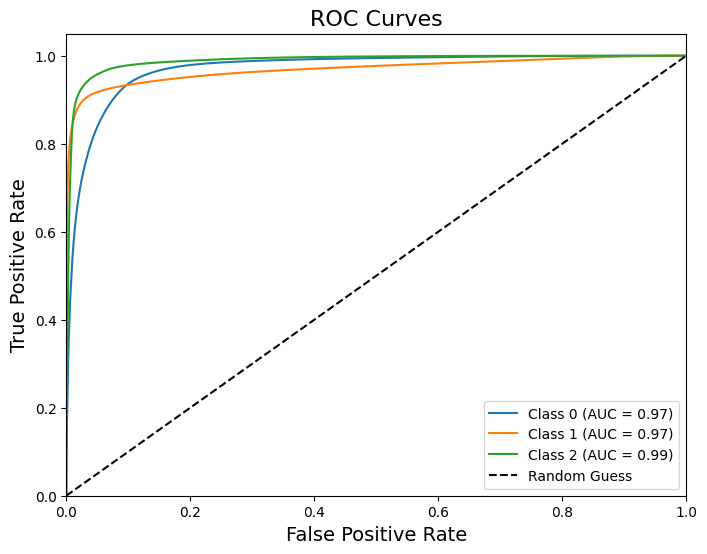

In [15]:
import os
import numpy as np
from keras.preprocessing import image
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Adjust these based on your setup
num_classes = 3  # e.g., Background=2, Disc=0, Cup=1
class_labels = [0, 1, 2]
input_size = 224

# Function to accumulate predictions and ground truths over the entire validation set
def accumulate_predictions(val_list, val_data_path, val_mask_path, model, input_size=224):
    # We'll store all predictions and ground truths for all pixels across the val set.
    # Each pixel is considered a sample.
    all_probs = []  # Will hold probabilities of shape (N, num_classes) where N is total number of pixels over val set
    all_gt = []     # Will hold ground truth class labels (N,)

    for img_name in val_list:
        mask_name = img_name  # Assuming same filename for mask
        img_path = os.path.join(val_data_path, img_name)
        mask_path = os.path.join(val_mask_path, mask_name)

        # Load the image and mask
        img, mask = load_single_image(img_path, mask_path, input_size)
        img_input = np.expand_dims(img, axis=0)

        # Predict probabilities
        # 'model.predict' should return a list if it's a multi-output model;
        # if your model returns a single output (probabilities), just adjust accordingly.
        predictions = model.predict(img_input)
        # final_output should be the last layer's output (N=1, H, W, C)
        # Here we assume predictions[-1] gives us the desired output if it's a multi-output model.
        final_output = predictions[-1][0]  # shape: (input_size, input_size, num_classes)

        ground_truth_mask = remap_mask_values(mask)  # shape: (input_size, input_size)

        # Flatten the arrays
        flat_probs = final_output.reshape(-1, num_classes)  # shape: (input_size*input_size, num_classes)
        flat_gt = ground_truth_mask.flatten()               # shape: (input_size*input_size, )

        # Accumulate
        all_probs.append(flat_probs)
        all_gt.append(flat_gt)

    # Concatenate all
    all_probs = np.concatenate(all_probs, axis=0)  # shape: (Total_pixels_in_val_set, num_classes)
    all_gt = np.concatenate(all_gt, axis=0)        # shape: (Total_pixels_in_val_set, )

    return all_probs, all_gt

def plot_roc_auc(all_probs, all_gt, class_labels):
    plt.figure(figsize=(8,6))
    # Compute ROC and AUC for each class in a one-vs-rest manner
    for cls in class_labels:
        # Binary ground truth for this class
        binary_gt = (all_gt == cls).astype(int)

        # Predicted probability for this class
        cls_probs = all_probs[:, cls]  # Probability of class 'cls'

        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(binary_gt, cls_probs)
        roc_auc = auc(fpr, tpr)
        print(roc_auc)

        plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {roc_auc:.2f})')

    # Plot random guess line
    plt.plot([0,1], [0,1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
all_probs, all_gt = accumulate_predictions(val_list, val_data_path, val_mask_path, my_model, input_size=224)
plot_roc_auc(all_probs, all_gt, class_labels=[0,1,2])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

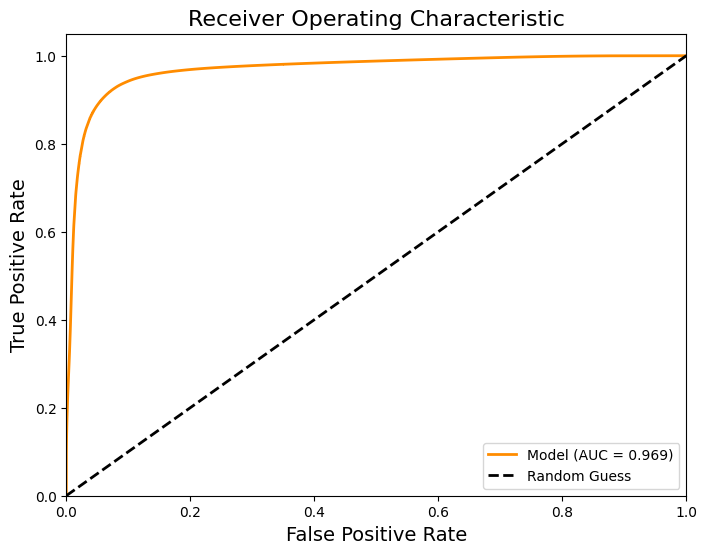

In [16]:
import os
import numpy as np
from keras.preprocessing import image
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Adjust these based on your setup
num_classes = 3  # e.g., 0=Disc, 1=Cup, 2=Background
input_size = 224

def plot_micro_average_roc(all_probs, all_gt, num_classes):
    # One-hot encode the ground truth for micro-average calculation
    all_gt_one_hot = to_categorical(all_gt, num_classes=num_classes)

    # Flatten arrays into a single binary classification problem (micro-average)
    y_true = all_gt_one_hot.ravel()
    y_score = all_probs.ravel()

    # Compute ROC curve and AUC for the micro-average
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Print the AUC value
    print(f"Micro-average AUC: {roc_auc:.4f}")

    # Plot the ROC curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Model (AUC = {:.3f})'.format(roc_auc))
    plt.plot([0,1],[0,1],'k--', lw=2, label='Random Guess')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
# Make sure val_list, val_data_path, val_mask_path, and my_model are defined.
all_probs, all_gt = accumulate_predictions(val_list, val_data_path, val_mask_path, my_model, input_size=input_size)
plot_micro_average_roc(all_probs, all_gt, num_classes=num_classes)
